<a href="https://colab.research.google.com/github/jx-dohwan/Deep_Learning_from_Scratch_2_study/blob/main/CH6_%EA%B2%8C%EC%9D%B4%ED%8A%B8%EA%B0%80_%EC%B6%94%EA%B0%80%EB%90%9C_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CH6_게이트가 추가된 RNN
> RNN은 순환 경로를 포함하며 과거의 정보를 기역할 수 있었다. 구조가 단순하여 구현도 쉽지만 문제는 성능이 좋지 못하다. 그 원인은 시계열 데이터에서 시간적으로 멀리 떨어진 장기 의존 관계를 잘 학습할 수 없다는데 있다.<br><br> 요즘에는 RNN대신에 LSTM이나 GRU라는 계층이 주로 쓰인다. LSTM이나 GRU에는 게이트라는 구조가 더해져 있는데 이 게이트 덕분에 시계열 데이터의 장기 의존 관계를 학습할 수 있다.<br><br> 이번장에서는 RNN의 문제점을 알아보고, 이를 대신하는 계층인 LSTM과 GRU와 같은 게이트가 추가된 RNN을 소개한다. 특히 장기기억을 가능하게 하는 메커니즘을 이해해본다.

## 1. RNN의 문제점
> RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어렵다. 그 원인은 BPTT에서 기울기 소실 혹은 기울기 폭발이 일어나기 때문이다.

### 1) RNN 복습
> RNN 계층은 시계열 데이터인 xt를 입력하면 ht를 출력한다. 이 ht는 RNN계층의 은닉 상태라고 하여 과거의 정보를 저장한다. RNN의 특징은 바로 이전 시각의 은닉 상태를 이용한다는 점이다. 이렇게 해서 과거 정보를 게승할 수 있다. <br><br> RNN계층의 순전파에서 수행하는 계산은 행렬의 곱과 합, 그리고 활성화 훔수이 tanh함수에 의한 변환으로 구성된다.

### 2) 기울기 소실 또는 기울기 폭발

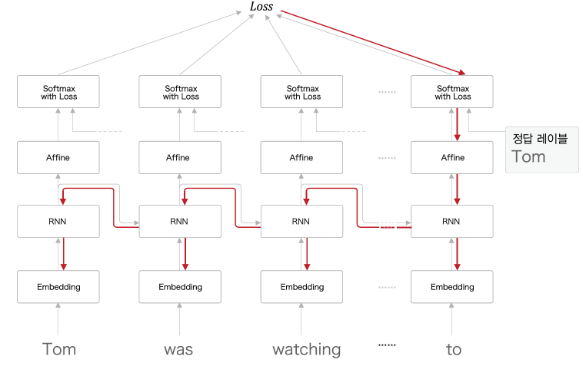

- RNN 계층이 과거 방향으로 의미 있는 기울기를 전달함으로써 시간 방향의 의존관게를 학습할 수 있는 것이다.
- 이때 기울기는 (원래대로라면) 학습해야 할 의미가 있는 정보가 들어있고
- 그것을 과거로 전달함으로써 장기 의존 관게를 학습한다.
- 하지만 만약 이 기울기가 중간에 사그라들면 가중치 매개변수는 전혀 갱신되지 않는다. 이 말은 장기 읜존 관계를 학습할 수 없게 ㄷ뇌다.
- 현재의 단순한 RNN게층에서는 시간을 거슬러 올라갈수록 기울기가 작아지거나 혹은 커질수 있다. 대부분 둘 중 하나의 운명을 걷게 된다.

### 3) 기울기 소실과 기울기 폭발의 원인

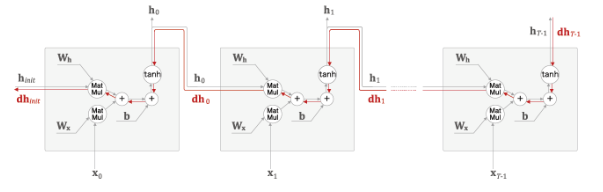

- 역전파에서 기울기가 tanh를 노드를 지날 때마다 값은 계속 작아진다는 뜻이다.
- 그래서 tanh 함수를 T번 통과하면 기울기도 T번 반복해서 작아지게 된다. 
- 긜고 역전파시 기울기는 MatMul 노드를 지날 때마다 어떻게 변화게 될까?

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47492 missing from current font.
  font.set_

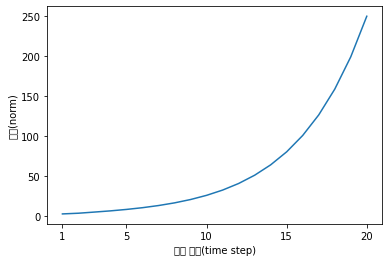

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()


[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44036 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45432 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47492 missing from current font.
  font.set_

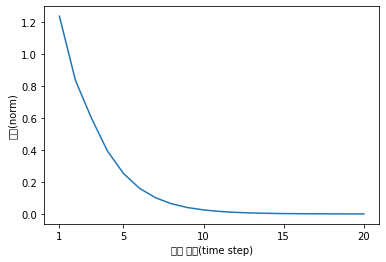

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

#Wh = np.random.randn(H, H)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()


- 기울기가 지수적으로 감소한다. 이것을 기울기 소실이라고 한다.
  - 기울기 소실이 일어나면 기울기가 매우 빠르게 작아진다.
  - 그리고 기울기가 일정 수준 이하로 작아지며 가중치 매개변수가 더 이상 갱신되지 않으므로 장기의존 관계를 학습할 수 없게 된다.

- 왜 이런 지수적인 기울기 소실이 일어날까?
  - 행렬 Wh를 T번 반복해서 곱했기 때문이다.
  - 만약 Wh가 스칼라라면 이야기는 단순해지는데 Wh가 1보다 크면 지수적으로 증가하고 1보다 작으면 지수적으로 감소한다.
  - 그럼 Wh가 스칼라가 아니고 행렬이라면?
    - 이 경우, 행렬의 특잇값이 척도가 된다.
    - 행렬의 특잇값이란 간단히 말하면 데이터가 얼마나 퍼져 있는지를 나타낸다.
    - 이 특잇값이(더 정확하게는 여러 특잇값 중 최댓값)이 1보다 큰지 여부를 보면 기울기 크기가 어떻게 변하는지 예측할 수 있다.

### 4) 기울기 폭발 대책
> 기울기 폭발의 대책으로는 전통적인 기법이 있다. 바로 기울기 클리핑(gradients clipping)이라는 법이다. 기울기 클리핑은 매우 단순하며, 그 알고리즘을 의사 코드로 쓰면 다음과 같다.

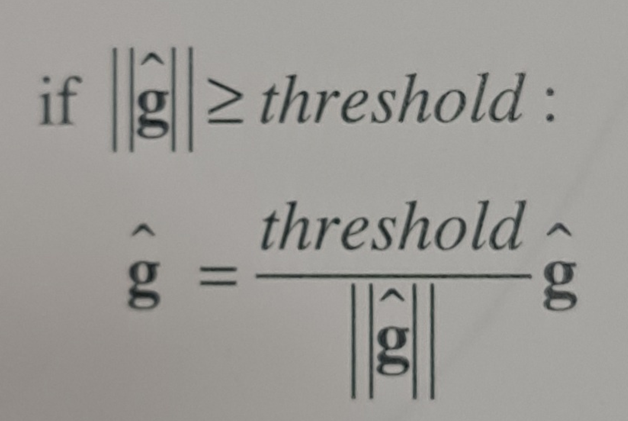

- g헷은 신경망에서 사용되는 모든 매개변수에 대한 기울기를 하나로 처리한다고 가장한 것이다.
- threshold를 문턱으로 설정
- 기울기 L2 norm이 문적값을 초과하면 두번째 줄의 수식과 같이 기울기를 수정한다.
- 이것이 기울기 클리핑이다. 